In [1]:
from utils import parse_trajectory

In [2]:
file_path = "traj.out"
traj_df = parse_trajectory(file_path)

In [3]:
traj_df.head()

,timestep,id,type,x,y,z,vx,vy,vz
0,0,1.0,1.0,-0.007764,0.003872,0.001848,-0.015794,0.007883,0.003761
1,0,2.0,1.0,-0.001109,2.697872,2.701748,-0.002250,0.010929,0.018818
2,0,3.0,1.0,2.692208,-0.009578,2.687882,-0.000595,-0.019489,-0.009397
3,0,4.0,1.0,2.698136,2.701272,-0.001149,0.011467,0.017850,-0.002335
4,0,5.0,1.0,0.003744,0.002798,5.389232,0.007615,0.005690,0.008608


/tmp/ipykernel_101228/1600757399.py:33: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(fit_maxwell_boltzmann, v_range, maxwell_boltzmann(v_range, T, m), p0=[T, m])


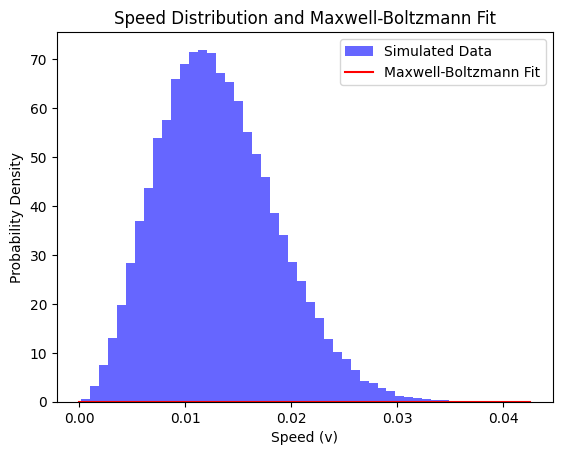

Fitted Temperature: 60.0 K
Fitted Mass: 100.0 amu


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.constants import Boltzmann
from scipy.optimize import curve_fit

# Constants
m = 100.0  # Particle mass (assume unit mass for simplicity)
T = 60  # Temperature in Kelvin (adjust based on your simulation)
kB = Boltzmann  # Boltzmann constant

# Function to calculate Maxwell-Boltzmann distribution
def maxwell_boltzmann(v, T, m):
    coeff = (m / (2 * np.pi * kB * T)) ** (3/2) * 4 * np.pi
    return coeff * v**2 * np.exp(-m * v**2 / (2 * kB * T))

# Function to fit Maxwell-Boltzmann distribution
def fit_maxwell_boltzmann(v, *params):
    T, m = params
    return maxwell_boltzmann(v, T, m)

# Extract speed data from the trajectory DataFrame
vx = traj_df["vx"].values
vy = traj_df["vy"].values
vz = traj_df["vz"].values
speeds = np.sqrt(vx**2 + vy**2 + vz**2)  # Calculate scalar speeds

# Plot histogram of speeds
plt.hist(speeds, bins=50, density=True, alpha=0.6, color='b', label="Simulated Data")

# Fit the histogram to Maxwell-Boltzmann distribution
v_range = np.linspace(0, np.max(speeds), 500)
popt, _ = curve_fit(fit_maxwell_boltzmann, v_range, maxwell_boltzmann(v_range, T, m), p0=[T, m])
T_fit, m_fit = popt

# Plot the fitted Maxwell-Boltzmann distribution
plt.plot(v_range, maxwell_boltzmann(v_range, T_fit, m_fit), 'r-', label="Maxwell-Boltzmann Fit")

# Add labels and legend
plt.xlabel("Speed (v)")
plt.ylabel("Probability Density")
plt.title("Speed Distribution and Maxwell-Boltzmann Fit")
plt.legend()
plt.show()

# Print fitted parameters
print(f"Fitted Temperature: {T_fit} K")
print(f"Fitted Mass: {m_fit} amu")

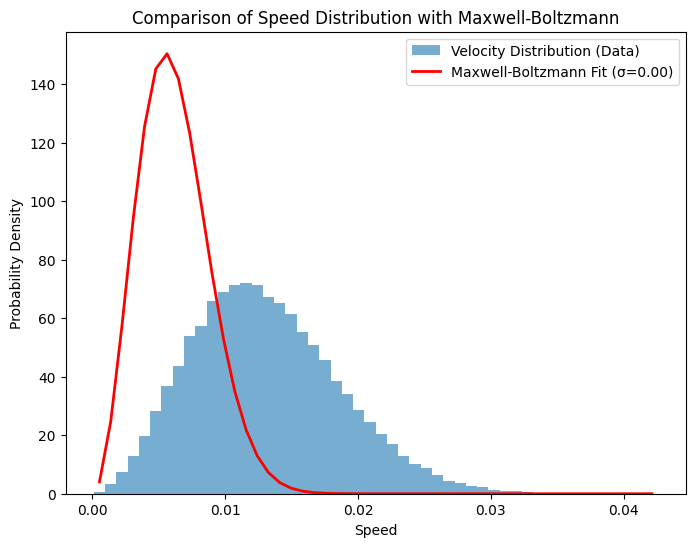

KS Statistic: 0.6032, P-Value: 0.0000e+00
The velocity distribution does not follow the Maxwell-Boltzmann distribution (reject null hypothesis).


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import maxwell, kstest

# Step 1: Calculate speeds from trajectory DataFrame
traj_df["speed"] = np.sqrt(traj_df["vx"]**2 + traj_df["vy"]**2 + traj_df["vz"]**2)

# Step 2: Create a histogram of speeds
speeds = traj_df["speed"].values
hist, bin_edges = np.histogram(speeds, bins=50, density=True)

# Bin centers for plotting
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Step 3: Fit the Maxwell-Boltzmann distribution
# Estimate the scale parameter (sigma) from the data
sigma_est = np.std(speeds) / np.sqrt(2)  # Standard deviation approximation

# Maxwell-Boltzmann theoretical PDF
maxwell_pdf = maxwell.pdf(bin_centers, scale=sigma_est)

# Step 4: Plot the experimental and theoretical distributions
plt.figure(figsize=(8, 6))
plt.hist(speeds, bins=50, density=True, alpha=0.6, label="Velocity Distribution (Data)")
plt.plot(bin_centers, maxwell_pdf, "r-", lw=2, label=f"Maxwell-Boltzmann Fit (σ={sigma_est:.2f})")
plt.xlabel("Speed")
plt.ylabel("Probability Density")
plt.title("Comparison of Speed Distribution with Maxwell-Boltzmann")
plt.legend()
plt.show()

# Step 5: Perform the Kolmogorov-Smirnov (KS) test
ks_stat, p_value = kstest(speeds, "maxwell", args=(0, sigma_est))
print(f"KS Statistic: {ks_stat:.4f}, P-Value: {p_value:.4e}")

# Interpretation of P-Value
if p_value > 0.05:
    print("The velocity distribution is consistent with the Maxwell-Boltzmann distribution (fail to reject null hypothesis).")
else:
    print("The velocity distribution does not follow the Maxwell-Boltzmann distribution (reject null hypothesis).")
